In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

### Basic csv manipulation with Pandas dataframe: filtering according to strings

In [2]:
# dataframe of emails from "sent" directory
df = pd.read_csv("../sent.csv")

In [3]:
# find emails in which a keyword appears
keyword = "legal"
mask_legal_mentioned1 = df["body"].str.match(keyword, case=False, na=False)     #.fillna(False)
mask_legal_mentioned2 = df["body"].str.contains(keyword, case=False, na=False)  # less strict
print("""Number of entries for:
       Stricter keyword matching: {}
       Less strict: {}""".format(mask_legal_mentioned1.sum(), mask_legal_mentioned2.sum()))
# df["body"][mask_legal_mentioned2]

Number of entries for:
       Stricter keyword matching: 4
       Less strict: 2450


In [4]:
# check email
df["body"][55129]

'I anticipate that Enron may have some legal issues in New York similar to the  issues Enron has faced in California.  Can you recommend a top notch trial  lawyer (similar to yourself) at any firms in New York?'

In [5]:
# who sent?
df["from"][55129]

'twanda.sweet@enron.com'

In [6]:
df["body"][2731]

"Please be sure this is in some legal record or something so I don't have  problems with this in the future. Thanks, Rick"

In [7]:
df["body"][56712]

'I have asked my asst, Twanda Sweet, to set up a meeting on Tues re this  issue. I will include Mike Day. Is there anyone else that should be in this  meeting---EES legal?'

### Preliminary tests for counting emails exchanged between two individuals

In [8]:
mask_twanda = df["from"].str.contains("twanda", case=False, na=False)

In [9]:
df["to"][mask_twanda].str.contains("david.delainey").sum()

6

In [10]:
for value in df["to"][mask_twanda].fillna('undefined').values:
    try:
        for recipient in value.split(','):
            print(recipient)
    except:
        print(value)

david.minns@enron.com
dick@jeanneret.com
drew.lynch@enron.com
hoyt.thomas@enron.com
andrea.yowman@enron.com
jo.hill@enron.com
david.o'dell@enron.com
lina.jimenez@enron.com
jane.allen@enron.com
michael.baust@enron.com
margaret.daffin@enron.com
elaine.schield@enron.com
jeff.skilling@enron.com
sherry.lessner@enron.com
fmackin@aol.com
emma.caplan@bootsnall.net
jo.hill@enron.com
andrea.yowman@enron.com
michelle.cash@enron.com
esholeen@bracepatt.com
bogden@ogwb.com
steve@ecogas.com
jcatanzariti@claytonutz.com.au
john.lambert@enron.com
drew.lynch@enron.com
robert.jones@enron.com
mark.greenberg@enron.com
debi.vanwey@enron.com
randy.young@enron.com
michelle.hargrave@enron.com
john.schwartzenburg@enron.com
fmackin@aol.com
gary.buck@enron.com
debi.vanwey@enron.com
robert.jones@enron.com
candace.womack@enron.com
tom.moore@enron.com
aallbritton@velaw.com
kim.melodick@enron.com
lclemmons@hotmail.com
cgunter@bracepatt.com
jsariego@mastec.com
mark.haedicke@enron.com
robert.williams@enron.com
brian.vas

In [11]:
def extract_emails_recipients(sender, df=df):
    """Deprecated. Superseded by the function count_sent_to
    ---
    Lists contacts from sender according to entries in the 'to' field.
    It does perform a non-strict check for sender, so please do provide a fairly constraining string
    or data series df.
    ---
    Usage example: extract_emails_recipients("twanda")"""
    
    assert type(sender) is str, "sender field must be a string"
    
    # data series selection (mask)
    from_sender = df["from"].str.contains(sender, case=False, na=False)
    
    # extract unique entries from the 'to' field
    recipients_set = set()
    for value in df['to'][from_sender].fillna('undefined').values:
        for recipient in value.split(','):
            recipients_set.add(recipient)
    
    return recipients_set

### Main routine for quantifying connections

In [12]:
def count_sent_to(sender, df=df, **kw):
    """Finds the contact list and contact frequency of a person.
            
    Arguments:
    ---
    * sender -- string identifying the sender according to the 'from' column
    * df -- pandas dataframe or series; defaults to pd.read_csv("../sent.csv")
    * kw -- extra optional arguments for numpy.unique
    
    Returns:
    ---
    * array of unique contacts from sender according to entries in the 'to' field
    * frequency in which those contacts show up in the 'to' field of dataframe for this sender
    
    Usage example:
    ---
    to_whom, counts = count_sent_to("twanda")
    
    Notes:
    ---
    Helper function for communication frequency histogram / network quantification.
    It performs a non-strict 'contains' check for sender. Providing a fairly constraining sender string 
    (or data series df) is advised.
    
    See also:
    ---
    numpy.unique
    """
    
    assert type(sender) is str, "sender field must be a string"
    
    # data series selection (mask)
    from_sender = df["from"].str.contains(sender, case=False, na=False)

    flatten = [entry for value in df['to'][from_sender].fillna('undefined').values for entry in value.split(',')]
    # TODO: implement cc and bcc
    
    return np.unique(flatten, return_counts=True, **kw)

### Example

In [13]:
def make_room_for_xlabels(fig, ax, N):
    """Helper function to adjust the figure size.
    N is the number of ticks (or a larger value) for nice padding."""
    # ref: https://stackoverflow.com/a/44864135

    fig.canvas.draw()
    tl = ax.get_xticklabels()
    maxsize = max([t.get_window_extent().width for t in tl])
    m = 0. # inch margin
    s = maxsize/fig.dpi * N + 2 * m
    margin = m/fig.get_size_inches()[0]

    fig.subplots_adjust(left=margin, right=1.-margin)
    fig.set_size_inches(s, fig.get_size_inches()[1])
    return

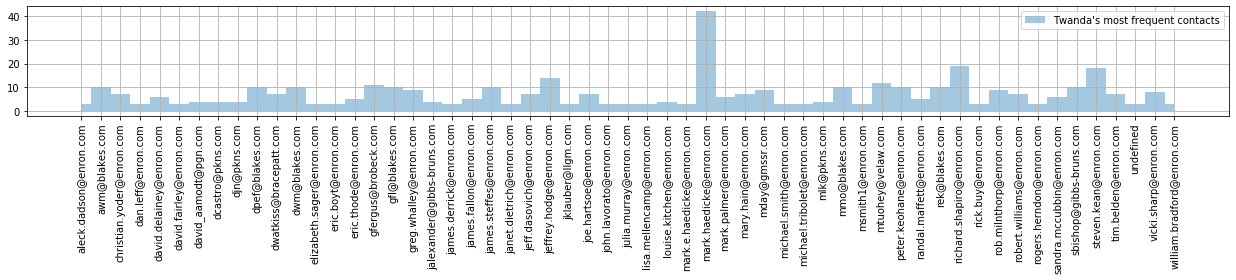

In [14]:
to_whom, counts = count_sent_to("twanda")
threshold = .7
most_frequent = counts >= np.quantile(counts, threshold)  # mask

fig, ax = plt.subplots()
ax.fill_between(to_whom[most_frequent], counts[most_frequent], label='Twanda\'s most frequent contacts',
                step='mid', alpha=0.4)
ax.xaxis.set_tick_params(rotation=90)
ax.grid(True)
ax.legend()
make_room_for_xlabels(fig, ax, 2*most_frequent.sum())
fig.tight_layout()
# fig.savefig("../figs/quantifying_connections_proof_of_concept.png")